# Modelos: Naive Bayes (SVM)

Mentor: Dr. Manuel David Morales (manuel.morales@saturdays.ai)

Primeramente, vamos a importar algunos modulos de uso común, asegurarnos de activar gráficas con MatplotLib "inline", y preparar una función para guardar las figuras. También checamos que la versión de Python instalada sea ≥ 3.5, y que la versión de scikit-learn sea ≥0.20. Python en versiones 2.x podría funcionar, pero dado que ya son versiones obsoletas, no son recomendables.

In [1]:
# Se requiere Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importaciones comunes
import numpy as np
import os

# Salidas aleatorias reproducibles
np.random.seed(42)

# Requerimientos para gráficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Las figuras se guardaran en la carpeta "images" junto al notebook
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Exploración dataset MNIST

In [3]:
# Importamos el dataset MNIST, lo guardamos como diccionario y mostramos la claves

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Descripción del dataset

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
# Guardamos los atributos y las clases objetivo en dos arreglos numpy: X e y, respectivamente
X, y = mnist["data"], mnist["target"]

# Mostrar dimension del dataset con los atributos
X.shape

(70000, 784)

In [5]:
# Mostrar valores unicos de atributos
np.unique(X)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [6]:
# Mostrar valores unicos de las clases objetivo
np.unique(y)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

Del dataset vemos lo siguiente: <br><br>
a) Hay 70,000 imágenes de 28x28(=784) pixeles <br>
b) Cada atributo es la intensidad de cada pixel, número entero de 0 (blanco) a 255 (negro) <br>
c) Las clases corresponde a los dígitos 0,1,2,...,9; en forma de cadenas, no números.

Saving figure some_digit_plot


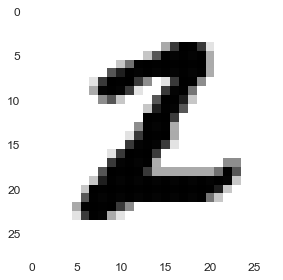

In [9]:
# Veamos una imagen cualquiera

some_digit = X[35290]
some_digit_image = some_digit.reshape(28, 28)
plt.grid(visible=None)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("on")

save_fig("some_digit_plot")
plt.show()

In [10]:
# ... y su respectiva etiqueta (clase objetivo) -notar que es una cadena

y[35290]

'2'

In [11]:
# Convertimos las clases objetivo en números enteros

y = y.astype(np.uint8)

Saving figure more_digits_plot


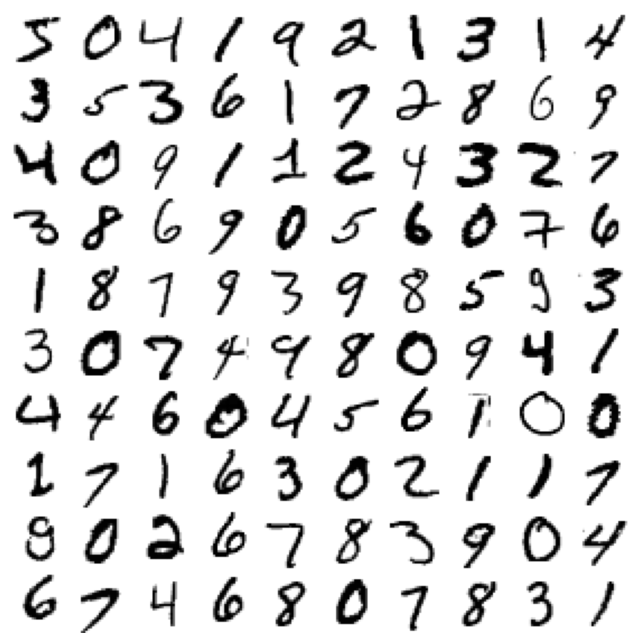

In [13]:
# Graficamos un conjunto de 100 imagenes

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

### Construcción de datasets de entrenamiento y prueba

In [14]:
# Dividimos el dataset en el conjunto de entrenamiento y conjunto de prueba
# 60,000 imágenes para entrenamiento, y 10,000 imágenes para test, con sus respectivas clases
# Observación: las imagenes ya están aleatorizadas, por lo que no hay problema
#              al considerar imagenes consecutivas del dataset original

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Clasificadores Naive Bayes

### 1) Classificación binaria (una clase vs. el resto)

In [15]:
# Consideramos un clasificador binario para detectar únicamente imágenes del número 7
# Nuevas clases objetivo: "True" para imágenes del número 7, "False" para imágenes de otros números

y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

In [16]:
# Importamos modelo Naive Bayes Gaussiano
from sklearn.naive_bayes import GaussianNB

# Creamos clasificador gaussiano
gnb = GaussianNB()

# Entrenamos el modelo usando: X_train, y_train_7
gnb.fit(X_train,y_train_7)

# Predecimos ingresando el número "some_digit" ya definido
y_pred_some_digit = gnb.predict([some_digit])
print(y_pred_some_digit)

[False]


In [17]:
# Predecimos para todo el conjunto de prueba

y_train_pred = gnb.predict(X_test)

In [18]:
# Calculamos la matriz de confusion

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_7, y_train_pred)

# NOTA IMPORTANTE: filas -> clases reales, columnas -> clases predichas
#
# FORMA DE LA MATRIZ DE CONFUSION      [ TN FP ]    (negatives: non-2 class)
#                                      [ FN TP ]    (positives: 2 class)

array([[6020, 2952],
       [  23, 1005]])

In [19]:
# Importamos metricas de scikit-learn
from sklearn import metrics

# Calculamos Exactitud (Accuracy): Nro. predicciones correctas / Total de predicciones
print("Accuracy:",metrics.accuracy_score(y_test_7, y_train_pred))

Accuracy: 0.7025


### 2) Classificación multiclase (todas las clases)

In [20]:
# Importamos modelo Naive Bayes Gaussiano
from sklearn.naive_bayes import GaussianNB

# Creamos clasificador gaussiano
gnb = GaussianNB()

# Entrenamos el modelo usando: X_train, y_train
gnb.fit(X_train, y_train)

# Predecimos considerando todo el test set
y_pred = gnb.predict(X_test)

In [21]:
# ¿Cuál es el número de imágenes mal clasificadas del test set?

print("Number of mislabeled images out of a total %d images : %d"    \
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled images out of a total 10000 images : 4442


In [22]:
# Importamos metricas de scikit-learn
from sklearn import metrics

# Calculamos Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5558


In [23]:
# Veamos ahora la matriz de confusión
from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_test, y_pred)

confu

array([[ 870,    0,    3,    5,    2,    5,   31,    1,   35,   28],
       [   0, 1079,    2,    1,    0,    0,   10,    0,   38,    5],
       [  79,   25,  266,   91,    5,    2,  269,    4,  271,   20],
       [  32,   39,    6,  353,    2,    3,   51,    8,  409,  107],
       [  19,    2,    5,    4,  168,    7,   63,    7,  210,  497],
       [  71,   25,    1,   20,    3,   44,   40,    2,  586,  100],
       [  12,   12,    3,    1,    1,    7,  895,    0,   26,    1],
       [   0,   15,    2,   10,    5,    1,    5,  280,   39,  671],
       [  13,   72,    3,    7,    3,   11,   12,    4,  648,  201],
       [   5,    7,    3,    6,    1,    0,    1,   13,   18,  955]])

Saving figure confusion_matrix_plot


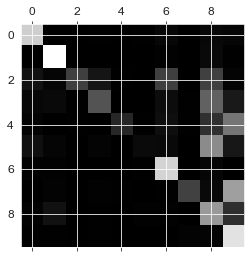

In [24]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(confu, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

### 3) Todas las clasificaciones binarias posibles (una clase vs. el resto, para cada clase)

In [28]:
# Importamos Naive Bayes Gaussiano
from sklearn.naive_bayes import GaussianNB

# Importamos cycle() para bucles eficientes
from itertools import cycle

# Importamos métricas: ROC curve y AUC (area bajo la curva ROC)
from sklearn.metrics import roc_curve, auc

# Importaciones para clasificación multiclase con binarizaciones multiples one vs. rest
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Importación para interpolación
from scipy import interp

In [29]:
# Binarización one vs. rest
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

# Construcción datasets de entrenamiento y prueba
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [30]:
# Entrenamos clasificador NB y predecimos utilizando todo el test set

gausnb_clf = OneVsRestClassifier(GaussianNB())

y_predict_proba = gausnb_clf.fit(X_train,y_train).predict_proba(X_test)

Evaluación: Curvas ROC -Receiver Operating Characteristic (Característica Operativa del Receptor)

In [31]:
# Generamos curvas ROC y calculamos AUC para cada binarización one vs. rest

# En general las curvas ROC involucran:

# FP Rate (FPR) = Fall-out = Especificidad = FP / (FP + TN )
# Porcentaje de muestras clasificadas como positivas que no son positivas

# TP Rate (TPR) = Recall = Sensibilidad = TP / ( TP + FN )
# Porcentaje de muestras positivas que son recuperadas

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
# Concatenamos todos los valores (discretos) de razones de falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolamos todas las curvas ROC en estos puntos
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finalmente calculamos el macro promedio
# Macro-promedio = [ sum_i=1^K M_i ] / K ,
# K: num. de clases, M_i: (valor de la métrica en la i-ésima clasificación binaria)

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/var/folders/h6/k3ph73lj23qbzlrl9r95w4lh0000gn/T/ipykernel_66506/1766009594.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


<Figure size 432x288 with 0 Axes>

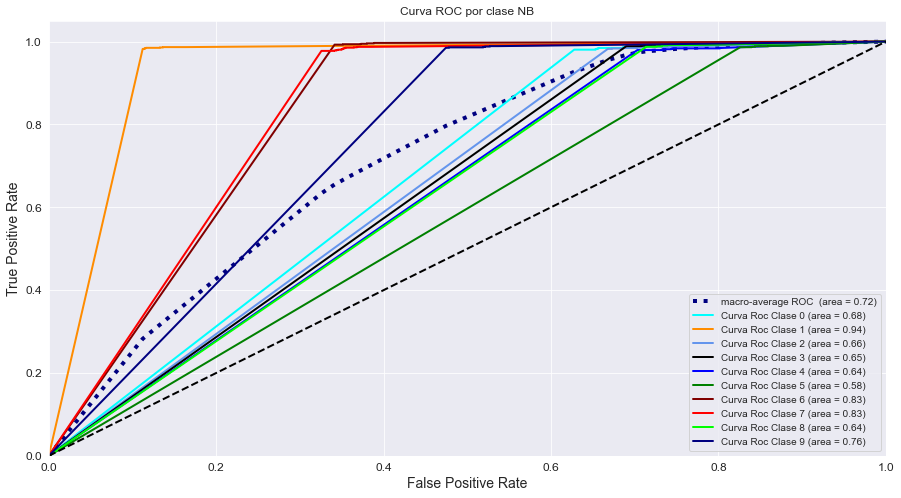

In [33]:
plt.figure()
plt.figure(figsize=(15,8))

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC  (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'black', 'blue', 'green', 'maroon', 'red', 'lime', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva Roc Clase {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC por clase NB')
plt.legend(loc="lower right")
plt.show()

##### En conclusión:
#### Clasificación binaria clase 1 vs. el resto mejor rendimiento
#### Clasificación binaria clase 5 vs. el resto peor rendimiento
#### Macro promedio de todas las curvas ROC se encuentra entre medio